In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score
import scipy

In [2]:
class GenericGRU(nn.Module):
    def __init__(self, T_no, H_no, layer_no, in_no, sub_no, device):
        super().__init__()
        
        self.T_no = T_no
        self.H_no = H_no
        self.layer_no = layer_no
        self.in_no = in_no
        self.device = device
        self.sub_no = sub_no
        
        #self.lstm = nn.GRU(self.in_no, self.H_no, self.layer_no, batch_first=True)
        #self.linear = nn.Linear(self.H_no, 1)
        
        self.rnn = nn.ModuleList()
        self.linear = nn.ModuleList()
        for s in range(self.sub_no):
            self.rnn.append(nn.GRU(1, self.H_no, self.layer_no, batch_first=True))
            self.linear.append(nn.Linear(self.H_no, 1))
        
        self.clust_raw = nn.Parameter(torch.zeros(self.sub_no, self.in_no), requires_grad=True)
        
    def forward(self, S, temp):
        T_data = S.shape[0]
        
        W_clust = F.softmax(self.clust_raw/temp, 0)
        sub_out = torch.zeros(T_data, self.sub_no).to(self.device)
        
        for s in range(self.sub_no):
            sub_in = torch.matmul(S, W_clust[s]) #(T_data)
            rnn_out, _ = self.rnn[s](sub_in.reshape(1,-1,1))
            sub_out[:,s] = sub_out[:,s] + self.linear[s](rnn_out.squeeze(0)).flatten()
        
        final = torch.sum(sub_out, 1)
        
        return final, sub_out

In [3]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust4-60"
cell_type = "CA1"
E_neural_file = "Espikes_neural.npz"
I_neural_file = "Ispikes_neural.npz"
V_file = "V_diff.npy"
#V_file = "vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep150_stimseed1.npy"
eloc_file = "Elocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep150_stimseed1.npy"
iloc_file = "Ilocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep150_stimseed1.npy"

E_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
I_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)
#V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)[:,:50000].flatten()
V = torch.from_numpy(V)
eloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+eloc_file)
iloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+iloc_file)

den_idx = np.unique(eloc[880:1120])
e_idx = np.where(np.isin(eloc[:,0], den_idx) == True)[0]
i_idx = np.where(np.isin(iloc[:,0], den_idx) == True)[0]
e_idx = torch.from_numpy(e_idx)
i_idx = torch.from_numpy(i_idx)

In [4]:
T_train = 149 * 1000 * 50
T_test = 1 * 1000 * 50
T_no = 501
H_no = 10
layer_no = 1
sub_no = 5
in_no = e_idx.shape[0] + i_idx.shape[0]
#in_no = 2200
save_dir = base_dir+cell_type+"_"+experiment+"/"
device = torch.device("cuda")

batch_size = 50000
iter_no = 20000
epoch_no = iter_no*batch_size//T_train 

In [5]:
V_train = V[:T_train].float()
V_test = V[T_train:T_train + T_test].to(device).float()

test_E_neural = E_neural[T_train:T_train+T_test].toarray()
test_I_neural = I_neural[T_train:T_train+T_test].toarray()
train_E_neural = E_neural[:T_train]
train_I_neural = I_neural[:T_train]

test_E_neural = torch.from_numpy(test_E_neural).float().to(device)
test_I_neural = torch.from_numpy(test_I_neural).float().to(device)

batch_no = (T_train - batch_size) * epoch_no
train_idx = np.empty((epoch_no, T_train//batch_size))
for i in range(epoch_no):
    part_idx = np.arange(0, T_train, batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

In [6]:
model = GenericGRU(T_no, H_no, layer_no, in_no, sub_no, device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0025)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

5665


In [7]:
temp_list = np.logspace(-0.5, -3, 50)
temp_count = 0
print(temp_list)

for i in tnrange(iter_no):
    model.train()
    optimizer.zero_grad()
    
    if (i%50 == 49) & (temp_count < 49):
        temp_count += 1
        print(temp)
    temp = temp_list[temp_count] 
    
    
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_size].toarray()
    batch_I_neural = train_I_neural[batch_idx : batch_idx+batch_size].toarray()
    batch_E_neural = torch.from_numpy(batch_E_neural).float().to(device)
    batch_I_neural = torch.from_numpy(batch_I_neural).float().to(device)
    batch_V = V_train[batch_idx : batch_idx+batch_size].to(device)
    
    V_pred, _ = model(torch.hstack((batch_E_neural[:,e_idx], batch_I_neural[:,i_idx])), temp)
    #V_pred = model(torch.hstack((batch_E_neural, batch_I_neural)))
    
    train_score = explained_variance_score(batch_V.cpu().detach().numpy(), V_pred.cpu().detach().numpy())
            
    #loss = torch.var(V_pred - batch_V)
    loss = torch.mean((V_pred - batch_V)**2)
    loss.backward()
    optimizer.step()
    
    if (i%50 == 49) or (i == 0):
        model.eval()
        test_V_pred, test_sub_out = model(torch.hstack((test_E_neural[:,e_idx], test_I_neural[:,i_idx])), temp)
        #test_V_pred = model(torch.hstack((test_E_neural, test_I_neural)))
                 
        test_score = explained_variance_score(V_test.cpu().detach().numpy(), test_V_pred.cpu().detach().numpy())
        test_mse = torch.mean((V_test-test_V_pred)**2).item()
        
        print(i, test_score, test_mse, train_score, loss.item())


[0.31622777 0.28117687 0.25001104 0.22229965 0.19765981 0.17575106
 0.1562707  0.13894955 0.12354829 0.10985411 0.09767781 0.08685114
 0.0772245  0.06866488 0.06105402 0.05428675 0.04826957 0.04291934
 0.03816213 0.03393222 0.03017115 0.02682696 0.02385344 0.02120951
 0.01885863 0.01676833 0.01490972 0.01325711 0.01178769 0.01048113
 0.0093194  0.00828643 0.00736795 0.00655129 0.00582514 0.00517947
 0.00460538 0.00409492 0.00364103 0.00323746 0.00287862 0.00255955
 0.00227585 0.00202359 0.00179929 0.00159986 0.00142253 0.00126486
 0.00112466 0.001     ]


<ipython-input-7-6e81a2938f7b>:5: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


0 0.011268317699432373 0.0277981236577034 0.009626626968383789 0.05029889941215515
0.31622776601683794
49 0.052405476570129395 0.02581530623137951 0.04686272144317627 0.027533182874321938
0.28117686979742307
99 0.10984307527542114 0.024236200377345085 0.09094977378845215 0.02661135606467724
0.250011038261793
149 0.2635619044303894 0.020091364160180092 0.22623473405838013 0.019110631197690964
0.22229964825261944
199 0.27949780225753784 0.019663050770759583 0.2731090188026428 0.02380291000008583
0.19765980717016338
249 0.28686660528182983 0.019397543743252754 0.26938146352767944 0.02088928408920765
0.1757510624854792
299 0.2909790277481079 0.019283009693026543 0.256216824054718 0.01770748943090439
0.15627069765469953
349 0.2937750220298767 0.019206883385777473 0.22325366735458374 0.02437637560069561
0.13894954943731375
399 0.3003970980644226 0.019137030467391014 0.22838258743286133 0.022437933832406998
0.12354828882567469
449 0.3031519055366516 0.01896275021135807 0.2748068571090698 0.02

4249 0.3517303466796875 0.017645498737692833 0.31879472732543945 0.0159424040466547
4299 0.34661638736724854 0.017794061452150345 0.3257450461387634 0.018086185678839684
4349 0.3347083330154419 0.018099673092365265 0.3649885654449463 0.013503937982022762
4399 0.35140836238861084 0.01765068620443344 0.3266907334327698 0.02256673015654087
4449 0.3498520851135254 0.01768922619521618 0.3638450503349304 0.021371889859437943
4499 0.34751641750335693 0.01782674342393875 0.33750492334365845 0.016476402059197426
4549 0.35178643465042114 0.017791012302041054 0.2978394627571106 0.02169455587863922
4599 0.3498970866203308 0.017687303945422173 0.3528686761856079 0.020044956356287003
4649 0.33756160736083984 0.018034890294075012 0.284282386302948 0.017506739124655724
4699 0.34527647495269775 0.017808526754379272 0.3766091465950012 0.013894963078200817
4749 0.35416674613952637 0.017592959105968475 0.3112812042236328 0.017278490588068962
4799 0.3490317463874817 0.017743147909641266 0.42173516750335693

KeyboardInterrupt: 

In [11]:
torch.save(model.state_dict(), "/media/hdd01/sklee/CA1_clust4-60/gru_l1_h10_model.pt")

In [12]:
model = GenericGRU(T_no, H_no, layer_no, in_no, device)
model.load_state_dict(torch.load("/media/hdd01/sklee/CA1_clust4-60/gru_l1_h10_model.pt"))
model.eval()

GenericGRU(
  (lstm): GRU(307, 10, batch_first=True)
  (linear): Linear(in_features=10, out_features=1, bias=True)
)

In [13]:
lin_out, rnn_out = model(torch.hstack((test_E_neural[:,e_idx], test_I_neural[:,i_idx])).cpu())

In [14]:
H = rnn_out.squeeze(0).cpu().detach().numpy()

[3 9 3 2 5 1 6 2 9 2]


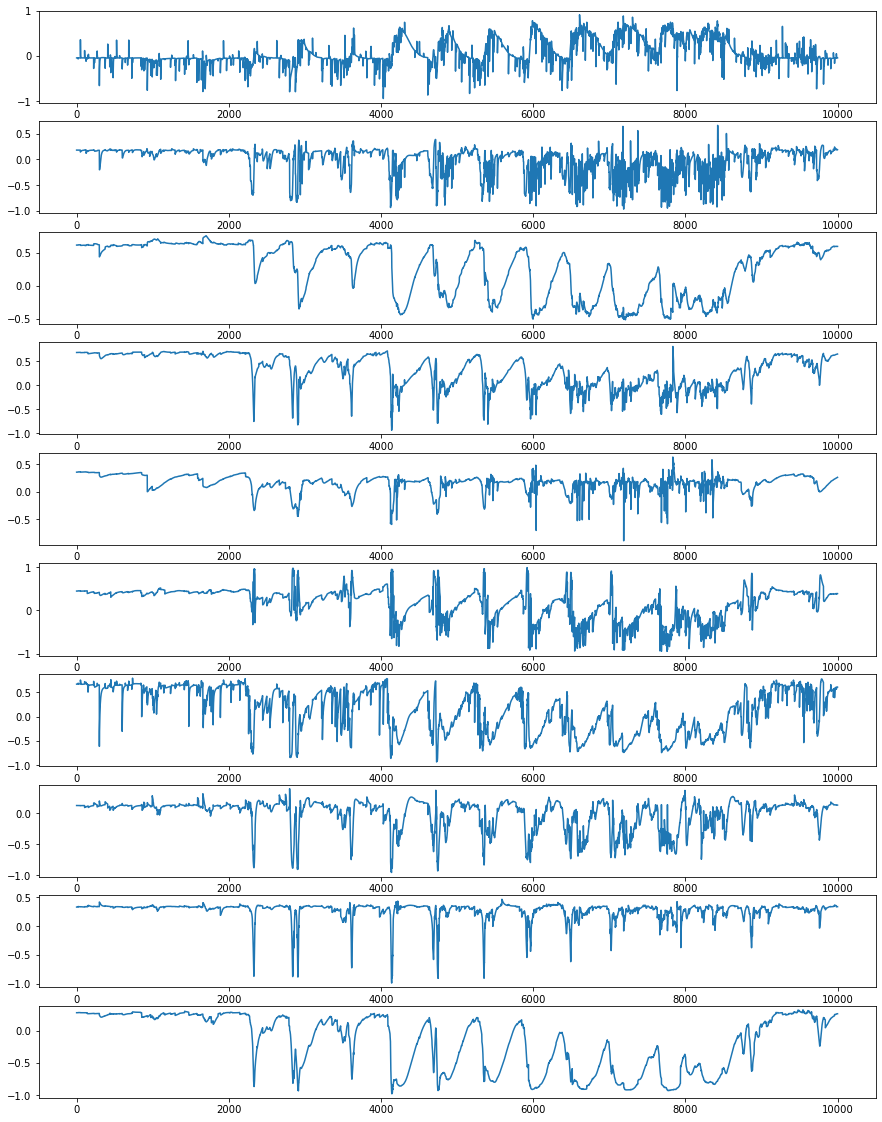

In [18]:
#idx = np.random.randint(0,10, 10)
print(idx)
fig, axs = plt.subplots(nrows=10, figsize=(15,20))
for i in range(10):
    axs[i].plot(H[:,i][16000:26000])

In [19]:
W = model.lstm.weight_ih_l0[:,].cpu().detach().numpy()
print(W.shape)

(30, 307)


0.72929996


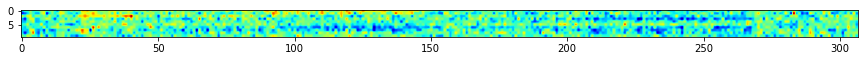

In [23]:
plt.figure(figsize = (15,5))
plt.imshow(W[:10], cmap="jet")
#plt.colorbar()
print(np.var(W[:10]))

0.3550791


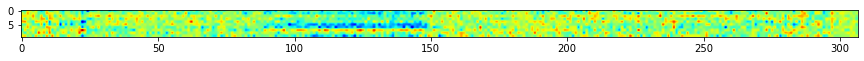

In [24]:
plt.figure(figsize = (15,5))
plt.imshow(W[20:30], cmap="jet")
#plt.colorbar()
print(np.var(W[20:30]))

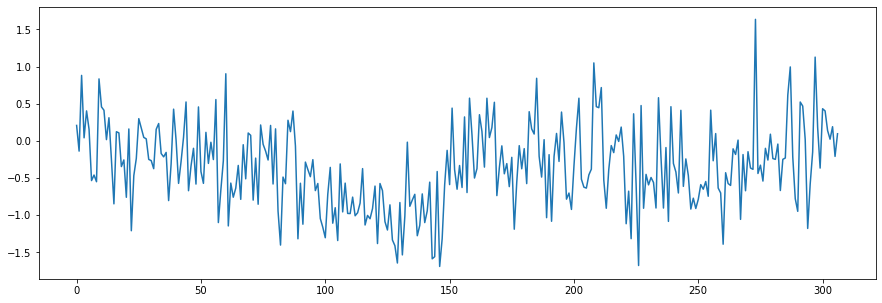

In [26]:
plt.figure(figsize = (15,5))
plt.plot(W[20:30][1])

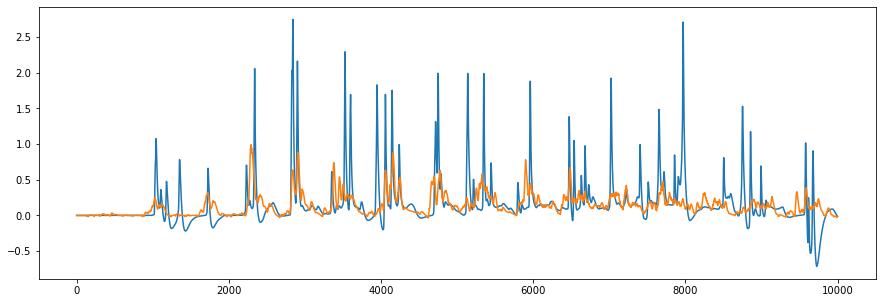

In [9]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy()[16000:26000])
plt.plot(test_V_pred.cpu().detach().numpy()[16000:26000])
#plt.plot(lin_out.flatten().cpu().detach().numpy()[16000:26000])

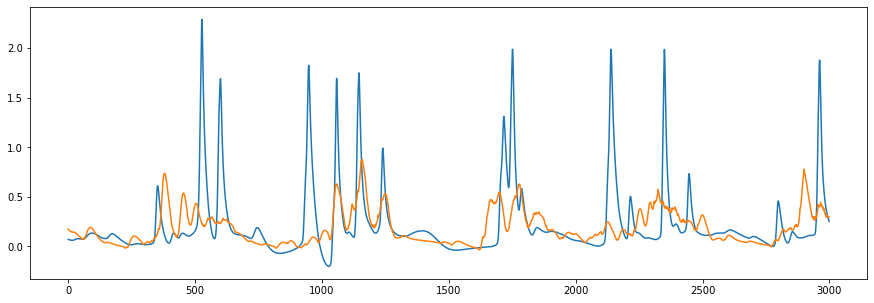

In [10]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy()[16000:26000][3000:6000])
plt.plot(test_V_pred.cpu().detach().numpy()[16000:26000][3000:6000])

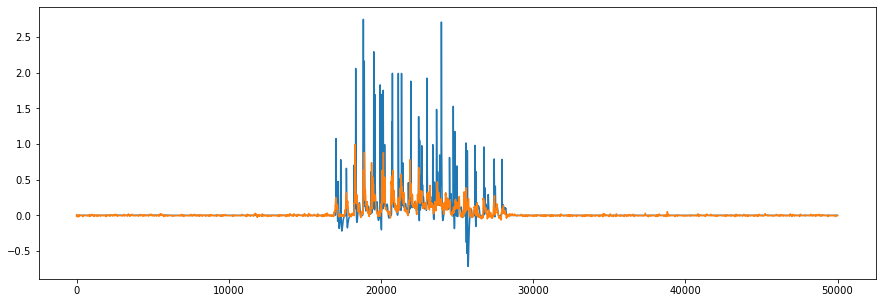

In [11]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy())
plt.plot(test_V_pred.cpu().detach().numpy())